#Installation using pip command

In [1]:
!pip install scsurv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=485f0a8f1268beff9081e8ad62f957040c5aa5de5699726f75ad76f45a1c8c69
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b8

#Import libraries

In [2]:
import scsurv.workflow as workflow
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from importlib.resources import files, as_file
import os

#Preparing simulated dataset
The scRNA-seq data used in this simulation is derived from the study by Wu et al. (https://doi.org/10.1038/s41588-021-00911-1).

In [3]:
base = files("scsurv") / "data"
with as_file(base / "tutolial_simulated_sc_reference.h5ad") as p:
    sc_adata = sc.read_h5ad(p)
with as_file(base / "tutolial_simulated_bulk.h5ad") as p:
    bulk_adata = sc.read_h5ad(p)
bulk_ncells_per_leiden = (bulk_adata.uns['n_cells_per_celltype_df'] / bulk_adata.uns['n_cells_per_celltype_df'].sum(axis=0)).T
setting_beta = pd.Series(bulk_adata.uns['setting_beta'], index = bulk_ncells_per_leiden.columns)
cell_type_df = sc_adata.obs['celltype_minor']
sc_adata.obs['setting_beta'] = sc_adata.obs['celltype_minor'].map(setting_beta).astype(float)

#Run scSurv
The workflow.run_scSurv function performs the three steps of scSurv (VAE, deconvolution, and survival analysis).

batch_key: Sample ID in single cell data

exp_name: Checkpoint file name

In [4]:
batch_key = 'orig.ident'
exp_name = 'tutolial_simulation.pt'
epoch = 10000
sc_adata, bulk_adata, model_params_dict, spatial_adata, scsurv_exp = workflow.run_scSurv(sc_adata, bulk_adata, exp_name, epoch, batch_key)

make_sample_one_hot_mat
{'1st_lr': 0.01, '2nd_lr': 0.01, '3rd_lr': 0.0001, 'patience': 10, 'bulk_seed': 0, 'x_batch_size_VAE': 1000, 'x_batch_size_DeepCOLOR': 1000, 'x_batch_size_scSurv': 500, 'n_var': 5000, 'usePoisson_sc': True, 'batch_key': 'orig.ident', 'n_obs_sc': 4305, 'n_obs_bulk': 300, 'method': 'efron', 'use_val_loss_mean:': True, 'bulk_validation_num_or_ratio': 0.2, 'bulk_test_num_or_ratio': 0.2, 'z_dim': 20, 'h_dim': 100, 'num_enc_z_layers': 1, 'num_dec_z_layers': 1, 'num_dec_p_layers': 1, 'num_dec_b_layers': 1, 'x_dim': 5000}
torch.cuda.is_available() True


/usr/local/lib/python3.12/dist-packages/torch/nn/init.py:582: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Start first opt lr= 0.01
epoch 0: train loss 9386.611 validation loss 8474.6357421875
epoch 50: train loss 3379.3449166666664 validation loss 3544.7939453125
epoch 100: train loss 2977.70925 validation loss 3129.51123046875
epoch 150: train loss 2761.3316666666665 validation loss 2942.663330078125
epoch 200: train loss 2629.5404166666667 validation loss 2822.506103515625
epoch 250: train loss 2519.6576666666665 validation loss 2741.8095703125
epoch 300: train loss 2452.9591666666665 validation loss 2674.81884765625
epoch 350: train loss 2401.63025 validation loss 2628.7587890625
epoch 400: train loss 2359.9295 validation loss 2592.697021484375
Early Stopping! at 422 epoch, best score=2585.605908203125
Done sc mode, Val Loss: 2583.78662109375 Test Loss: 2668.282958984375
bulk mode lr= 0.01
epoch 0: train loss 12279.492333333334 validation loss 28488.943359375
epoch 50: train loss 11012.762 validation loss 25589.61328125
epoch 100: train loss 10336.296333333334 validation loss 24023.6796

The workflow.post_process function saves the results of the three steps to anndata

In [5]:
sc_adata, bulk_adata, _ = workflow.post_process(scsurv_exp, sc_adata, bulk_adata)

vae_results
all_x_correlation_gene 0.316 train_x_correlation_gene 0.323 val_x_correlation_gene 0.282 test_x_correlation_gene 0.282
deconvolution_results
bulk_correlation_gene 0.7352219196856122
Done post process


#Visualization

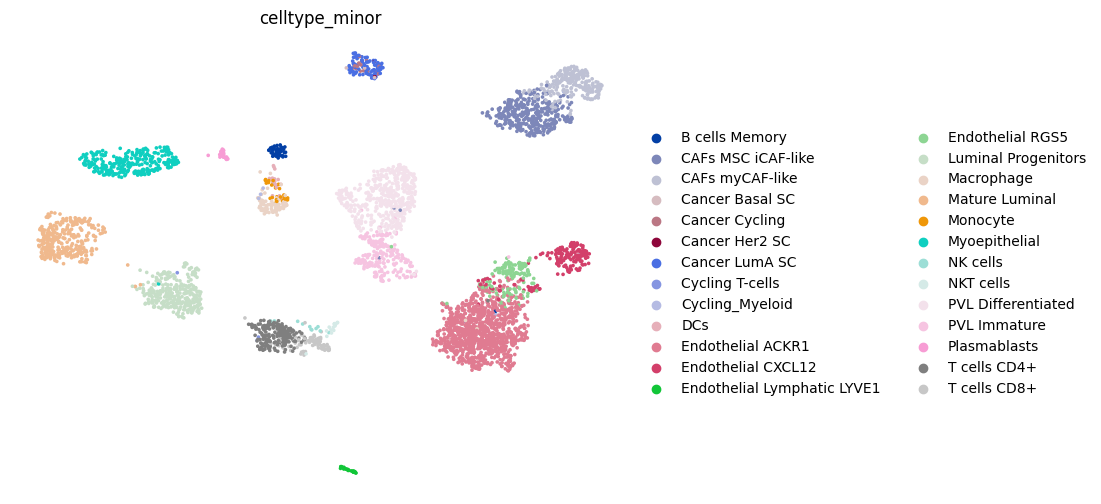

In [6]:
os.makedirs('fig', exist_ok=True)
fig, ax = plt.subplots(figsize=(8, 6))
sc.pl.umap(sc_adata, color='celltype_minor', ax=ax, show=False, colorbar_loc=None, frameon=False)
plt.savefig('fig/simulation_umap_celltype_minor.png', bbox_inches='tight')

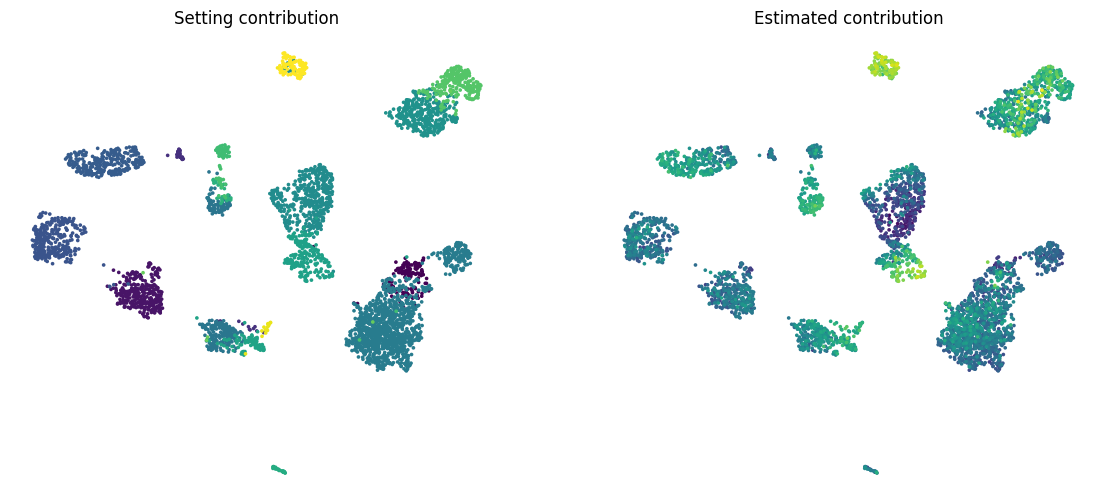

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sc.pl.umap(sc_adata, color='setting_beta', ax=ax1, show=False, colorbar_loc=None, frameon=False, title='Setting contribution')
sc.pl.umap(sc_adata, color='beta_z', ax=ax2, show=False, colorbar_loc=None, frameon=False, title='Estimated contribution')
plt.savefig('fig/simulation_umap_setting_and_estimated_beta.png')

In [8]:
estimated_p_sc_level = pd.DataFrame(sc_adata.obsm['map2bulk'].T, index=bulk_adata.obs_names, columns=sc_adata.obs_names)
bulk_ncells = bulk_adata.uns['n_cells_per_celltype_df'].T
estimated_p_cluster = pd.DataFrame(index=bulk_ncells.index, columns=bulk_ncells.columns)
for item in bulk_ncells.columns:
    item_idx = sc_adata[sc_adata.obs['celltype_minor']==item].obs.index
    estimated_p_cluster[item] = estimated_p_sc_level[item_idx].sum(axis=1)

deconv_corr = estimated_p_cluster.corrwith(bulk_ncells, axis=1, method='pearson')
print('scSurv deconvolution correlation', deconv_corr.median())

beta_means = {item: sc_adata[sc_adata.obs['celltype_minor'] == item].obs['beta_z'].mean() for item in bulk_ncells.columns}
beta_corr = pd.Series(beta_means).corr(setting_beta)
print('scSurv contribution correlation', beta_corr)

scSurv deconvolution correlation 0.5566366855334364
scSurv contribution correlation 0.5401224302010111
